# LE transformation

We use either Gompertz or Weibull:

The only change is that instead of having a continuous variable for time we let the effects of time be piecewise:

Let D1=1 if year is less than 1940 and 0 otherwise
Let D2=1 if year is more than or equal to 1940 but less than 1970 and 0 otherwise
Let D3=1 if year >=1970

The Gompertz model will be:


$$ln(-lnY(t))=Ao+A1lnGDP+B2D2+B3*D3$$

with D1 defined as the left out category and its effects absorbed in Ao
Then we make Ao, A1, B2 and B3 be random coefficients depending on country
The idea is that if the shifts did happen in the time periods specified by the dummies, then the corresponding coefficient will identify the magnitude of the shifts. Also with this specification we do not rob GDP from effects

In [ ]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(sdazar)
library(data.table)
library(MASS)

library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

In [7]:
# load data

df = data.table(read_stata('../data/LA_uncertainty.dta'))

df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))
df = df[complete.cases(df)]

df[, le_log := scale(log(le), scale=FALSE)]
df[, gdp_log := scale(log(gdp), scale=FALSE)]
df[, year_log := scale(log(year), scale=FALSE)]
df[, year_c := scale(year, scale=FALSE)]

In [9]:
# dummies

# Let D1=1 if year is less than 1940 and 0 otherwise
# Let D2=1 if year is more than or equal to 1940 but less than 1970 and 0 otherwise
# Let D3=1 if year >=1970

df[, y1900 :=  ifelse(year<1940, 1, 0)]
df[, y1940 :=  ifelse(year>=1940 & year<1970, 1, 0)]
df[, y1970 := ifelse(year>=1970, 1, 0)]

In [11]:
head(df)

ctry,year,gdp,le,le_log,gdp_log,year_log,year_c,y1900,y1940,y1970
2020,1900,2875.352,41.14719,-0.2832005,-0.0001331202,-0.03272400,-63.42566,1,0,0
2020,1905,3478.617,36.49913,-0.4030676,0.1903267151,-0.03009587,-58.42566,1,0,0
2020,1910,3821.710,41.14719,-0.2832005,0.2843900144,-0.02747464,-53.42566,1,0,0
2020,1915,3243.723,38.29062,-0.3551511,0.1204137191,-0.02486026,-48.42566,1,0,0
2020,1920,3473.069,39.97605,-0.3120756,0.1887304573,-0.02225270,-43.42566,1,0,0
2020,1925,3919.410,41.77955,-0.2679491,0.3096329779,-0.01965191,-38.42566,1,0,0


# Variable transformation

- Suppose for each country we have the maximum value of life expectancy in the last year of observation, max(E).
- Then, for each year t compute Y(t)= E(t)/Max(E). We now have two options, a Gompertz or a Weibull:


### Gompertz

$$Z(t)=ln(-ln Y(t))=A + Bt$$
and we make A a function of GDP so the model is as we have it now but with Z(t) as dependent variable. That is the baseline model will look as follows:

$$Z(t) = Ao+A1lnGDP+B*t$$

and Ao, A1 and B will be specified as a random effects


In the Gompertz we can use centered values of t but not in the Weibull unless we transform t

In [14]:
df[, y := le/max(le+1.05), by = ctry] # by country, really!!!

In [15]:
max_le = df[, .(max_le = max(le+1.05)), by = ctry] # by country, really!!!

In [16]:
df[, gy := log(-log(y))]
summary(df$gy)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-4.361151 -2.495325 -1.378437 -1.609385 -0.476357 -0.003456 

Does this make sense? Negative values?

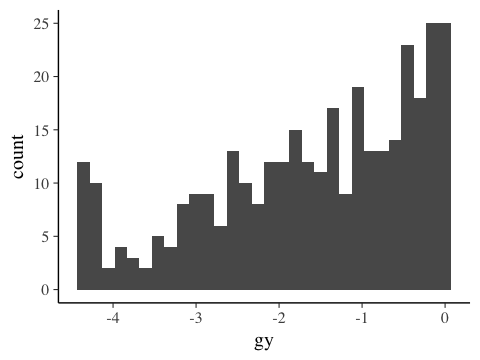

In [17]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(df, aes(gy)) + geom_histogram(bins=30)

In [ ]:
m1 = brm(formula = gy ~ gdp_log + y1940 + y1970  +
         ( gdp_log + y1940 + y1970 | ctry), 
    data = df)

In [23]:
summary(m1)

Warning message:
“There were 3 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: gy ~ gdp_log + y1940 + y1970 + (gdp_log + y1940 + y1970 | ctry) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry (Number of levels: 19) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.64      0.19     0.32     1.07       1026 1.00
sd(gdp_log)                0.65      0.20     0.32     1.10        989 1.00
sd(y1940)                  0.23      0.15     0.01     0.58        873 1.01
sd(y1970)                  0.46      0.21     0.07     0.91        626 1.00
cor(Intercept,gdp_log)     0.15      0.31    -0.50     0.67       1270 1.00
cor(Intercept,y1940)      -0.01      0.40    -0.76     0.75       4000 1.00
cor(gdp_log,y1940)         0.27      0.44    -0.68     0.92       1225 1.00
cor(Intercep

### Plot predictions

In [24]:
pred = cbind(df[, .(ctry, le, year, y1940, y1970, gdp_log, gy)], predict(m1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))
pred = merge(pred, max_le, by='ctry')

get_orig_values_gompertz = function(x, max_value) { 
    return ( (exp(-exp(x)) * max_value ))
}


In [25]:
pred[,  `:=` (
    m = get_orig_values_gompertz(m, max_le), 
    lo = get_orig_values_gompertz(lo, max_le),
    hi = get_orig_values_gompertz(hi, max_le)
    )]

In [26]:
countries = unique(pred$ctry)

In [27]:
for (i in 1:length(countries)) {
    assign(paste0('plot', i), 
           ggplot(pred[ctry==countries[i]], aes(x=year, y=le)) + 
           geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
           geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
           geom_point(size=1, color='#e34a33', alpha=0.4) +
           labs(title=paste0('Country ',countries[i])) + 
           ylim(min(df$le)-30.0, max(df$le)+20.0) + 
           xlim(min(df$year), max(df$year)) + theme_minimal()
       )

}

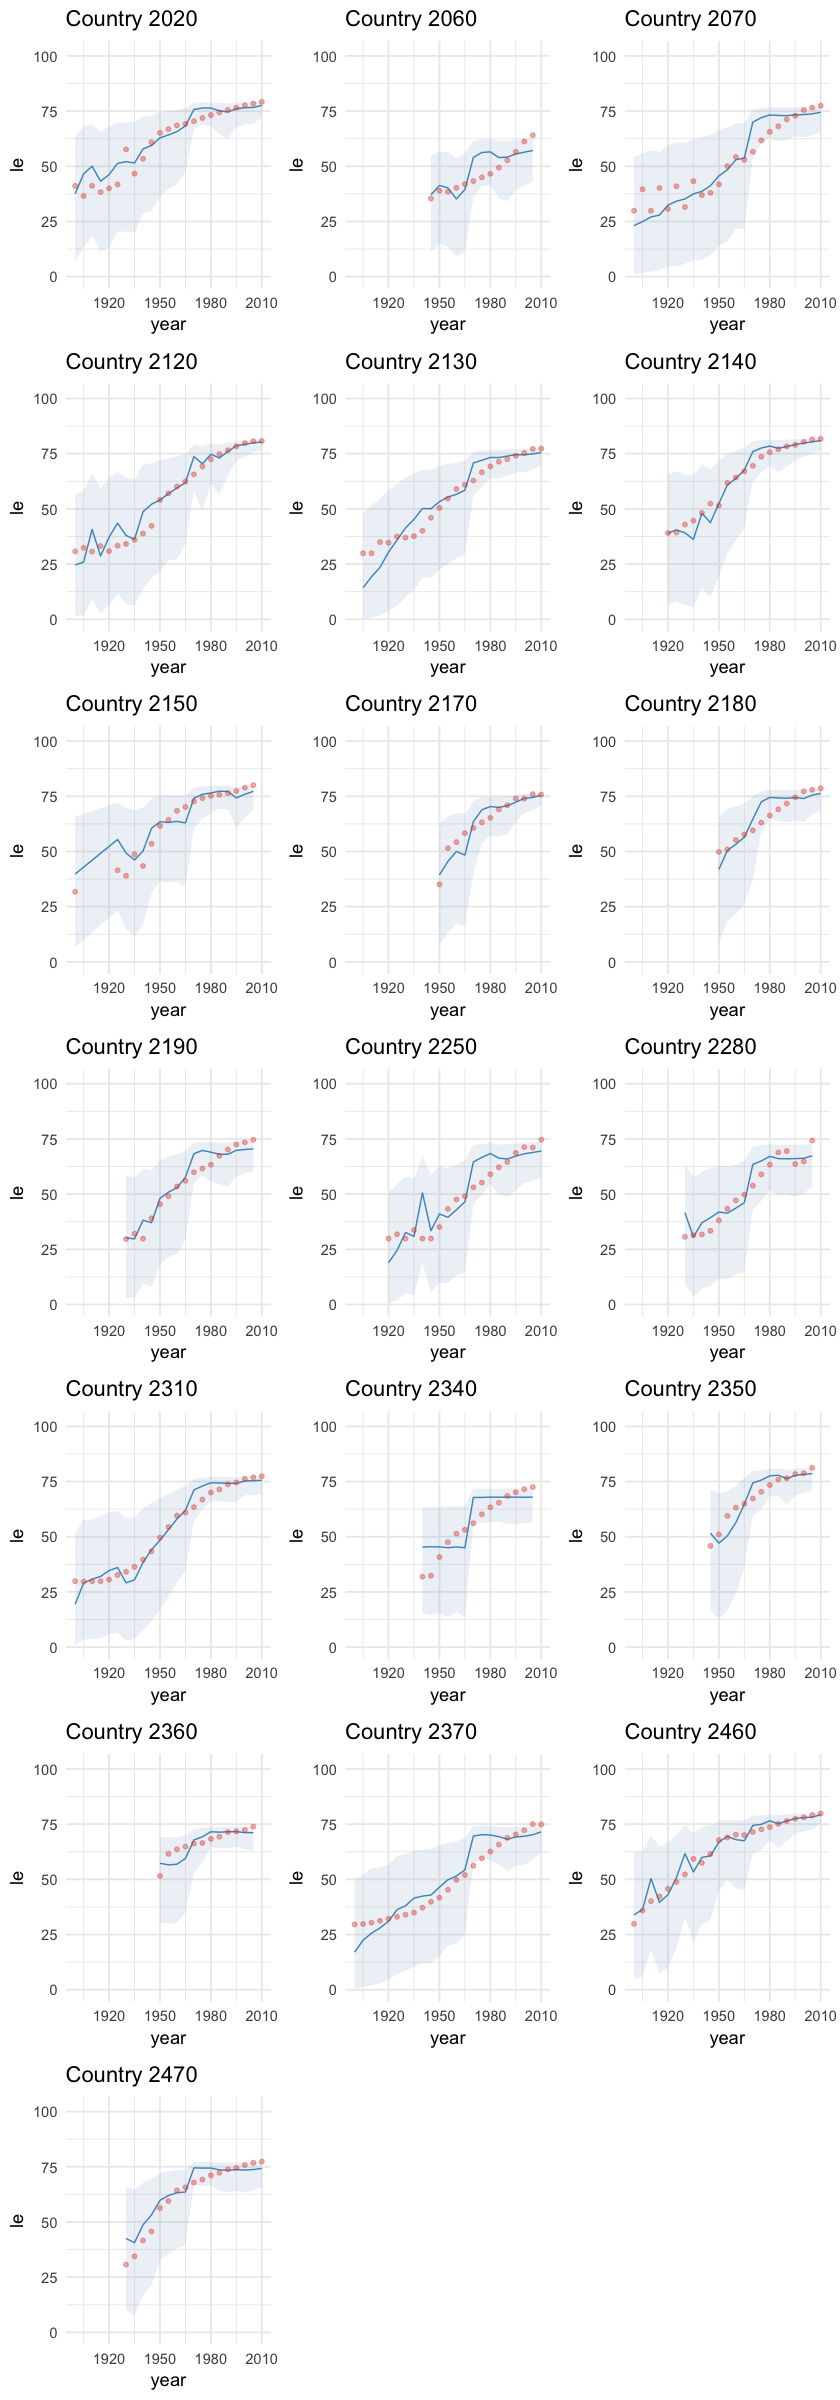

In [28]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(countries), collapse='+'), '+plot_layout(ncol = 3)')))

## Weibull

$$ln(-ln(1-Y(t))=C+D*lnt$$

and we make C a function of GDP and the model is as we have it now but with W(t) as dependent variable.

So what I did is:


$$W(t) = \alpha+\beta_g lnGDP+\beta_t*lnt$$

and $\alpha$, $\beta_g$ and $\beta_t$ are be specified as a random effects

The Weibull model should look somewhat different than the form we specified before:

$$ ln(-ln(1-Y(t))=Co + C1lnGDP + Dlnt +B2D2+B3D3 $$

In this case we maintain the log of time but allow the constant to shift.

Clearly this model should fit much better but has an extra parameter

In [29]:
df[, wy := log(-log(1-y))]
df[, year_ln := log(year)]

In [30]:
summary(df$wy)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.7750 -0.2603  0.4067  0.3615  0.9307  1.4742 

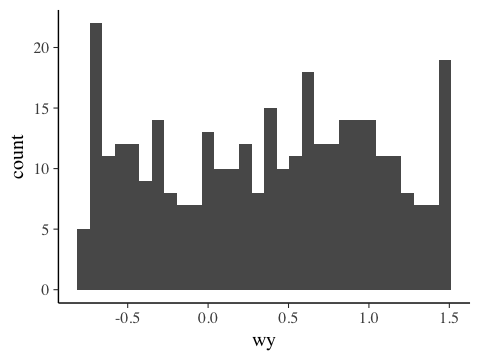

In [31]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(df, aes(wy)) + geom_histogram(bins=30)

In [34]:
m2 = brm(formula = wy ~ gdp_log + year_log +  y1940 + y1970 + 
         (gdp_log + year_log + y1940 + y1970 | ctry), 
    data = df)

Compiling the C++ model
Start sampling


In [35]:
summary(m2)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ year_log + gdp_log + y1940 + y1970 + (gdp_log + y1940 + y1970 | ctry) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry (Number of levels: 19) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.20      0.04     0.14     0.30       1621 1.00
sd(gdp_log)                0.20      0.05     0.11     0.32       1215 1.00
sd(y1940)                  0.13      0.04     0.06     0.22       1308 1.00
sd(y1970)                  0.09      0.05     0.01     0.19        543 1.01
cor(Intercept,gdp_log)    -0.48      0.26    -0.86     0.11       1214 1.00
cor(Intercept,y1940)       0.25      0.29    -0.33     0.78       2122 1.00
cor(gdp_log,y1940)         0.34      0.29    -0.26     0.82       2315 1.00
c

In [38]:
pred = cbind(df[, .(ctry, le, year, year_log, gdp_log, wy)], predict(m2))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))
pred = merge(pred, max_le, by='ctry')

In [39]:
get_orig_values_weibull = function(x, max_value) { 
    return ( (1 - exp(-exp(x))) * max_value )
}

In [40]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_le), 
    lo = get_orig_values_weibull(lo, max_le),
    hi = get_orig_values_weibull(hi, max_le)
    )]

In [41]:
for (i in 1:length(countries)) {
    assign(paste0('plot', i), 
           ggplot(pred[ctry==countries[i]], aes(x=year, y=le)) + 
           geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
           geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
           geom_point(size=1, color='#e34a33', alpha=0.4) +
           labs(title=paste0('Country ',countries[i])) + 
           ylim(min(df$le)-25.0, max(df$le)+25.0) + 
           xlim(min(df$year), max(df$year)) + theme_minimal()
       )

}

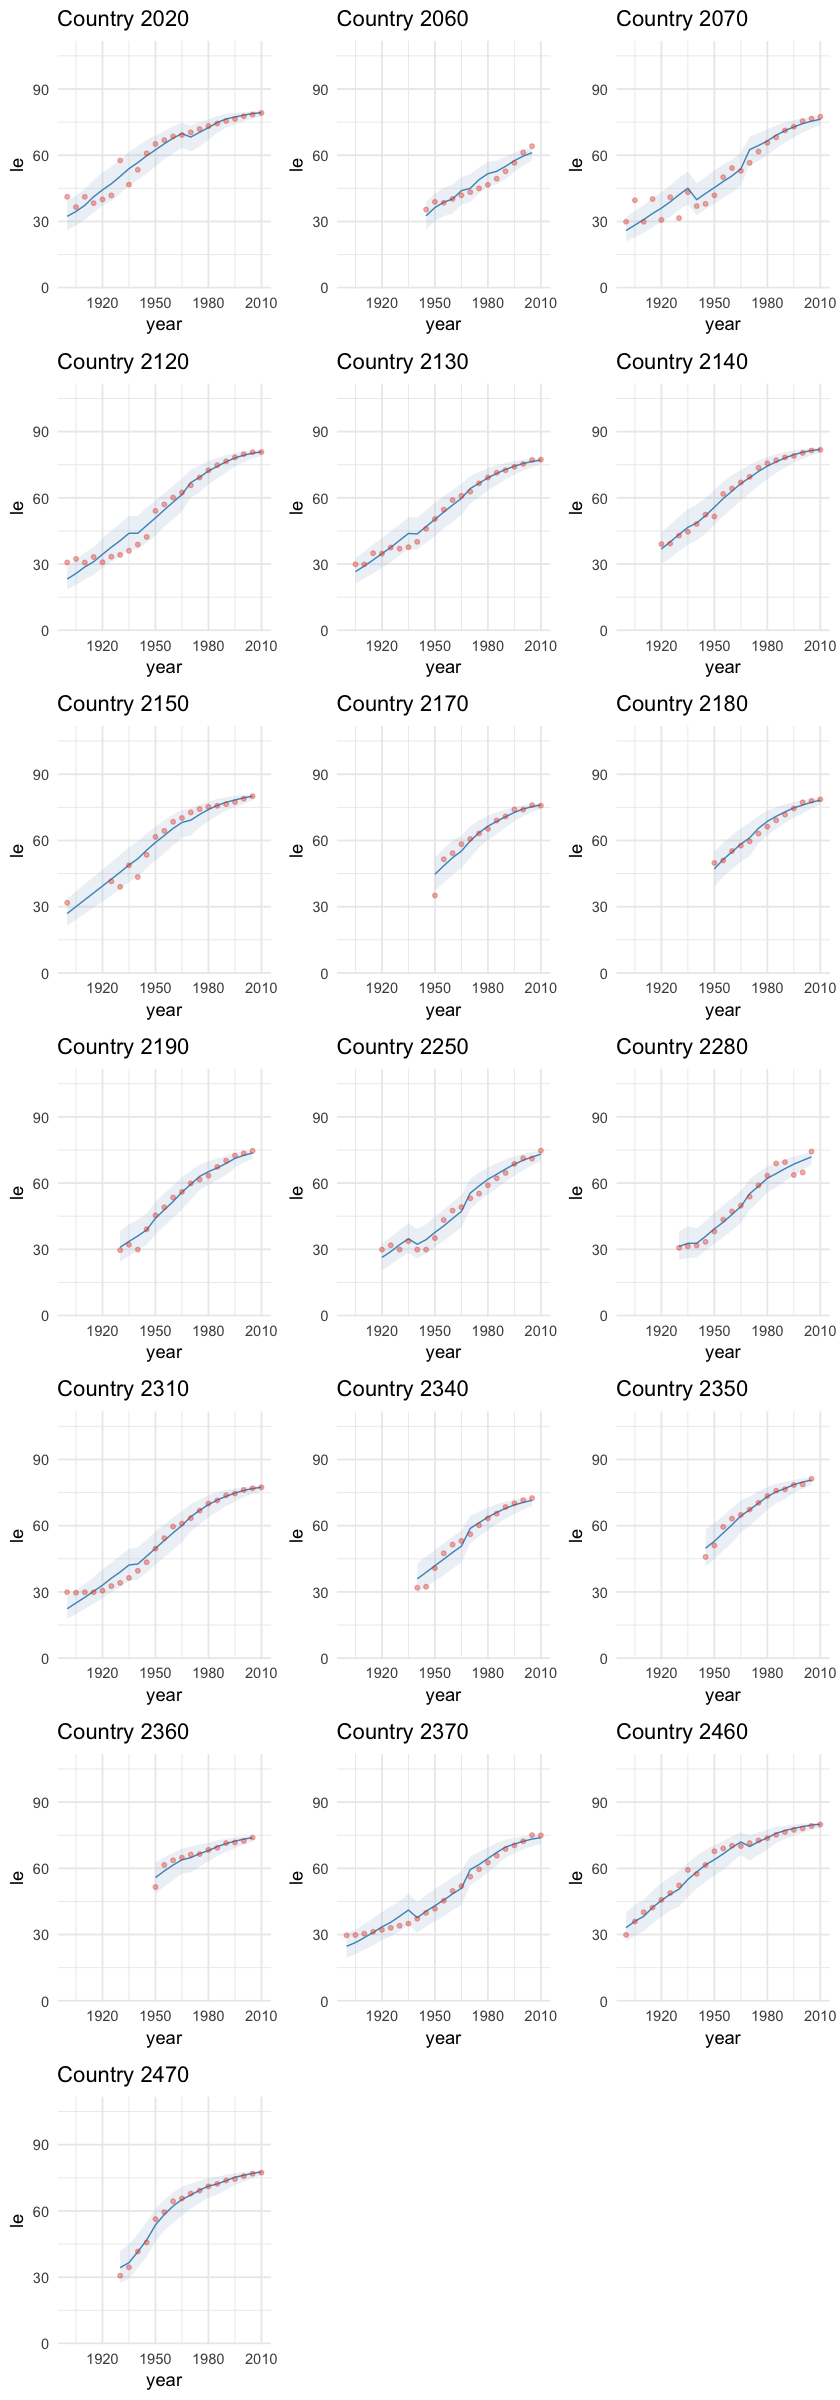

In [42]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(countries), collapse='+'), '+plot_layout(ncol = 3)')))

# My proposal 

In [52]:
m3 = brm(formula = le_log ~ gdp_log + (gdp_log|ctry) + (1|year), 
    data = df)

Compiling the C++ model
Start sampling


In [86]:
summary(m3)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: le_log ~ gdp_log + (gdp_log | ctry) + (1 | year) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry (Number of levels: 19) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.13      0.03     0.09     0.19       1145 1.00
sd(gdp_log)                0.11      0.02     0.07     0.17       1177 1.00
cor(Intercept,gdp_log)    -0.80      0.14    -0.97    -0.42       1386 1.00

~year (Number of levels: 23) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.36      0.06     0.26     0.49        898 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept    -0.08      0.08    -0.25     0.07        696 1.00
gdp_log     

In [88]:
pred = cbind(df[, .(ctry, le, le_log, year, gdp_log, wy)], predict(m3))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))
pred = merge(pred, max_le, by='ctry')

In [89]:
get_orig_values_logcenter = function(x, mean_value) { 
    return( exp( x + mean_value))
}

In [90]:
mean_le_log = mean(log(df$le))

pred[,  `:=` (
    m = get_orig_values_logcenter(m, mean_le_log), 
    lo = get_orig_values_logcenter(lo, mean_le_log),
    hi = get_orig_values_logcenter(hi, mean_le_log)
    )]

In [91]:
for (i in 1:length(countries)) {
    assign(paste0('plot', i), 
           ggplot(pred[ctry==countries[i]], aes(x=year, y=le)) + 
           geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
           geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
           geom_point(size=1, color='#e34a33', alpha=0.4) +
           labs(title=paste0('Country ',countries[i])) + 
           ylim(min(df$le)-25.0, max(df$le)+25.0) + 
           xlim(min(df$year), max(df$year)) + theme_minimal()
       )

}

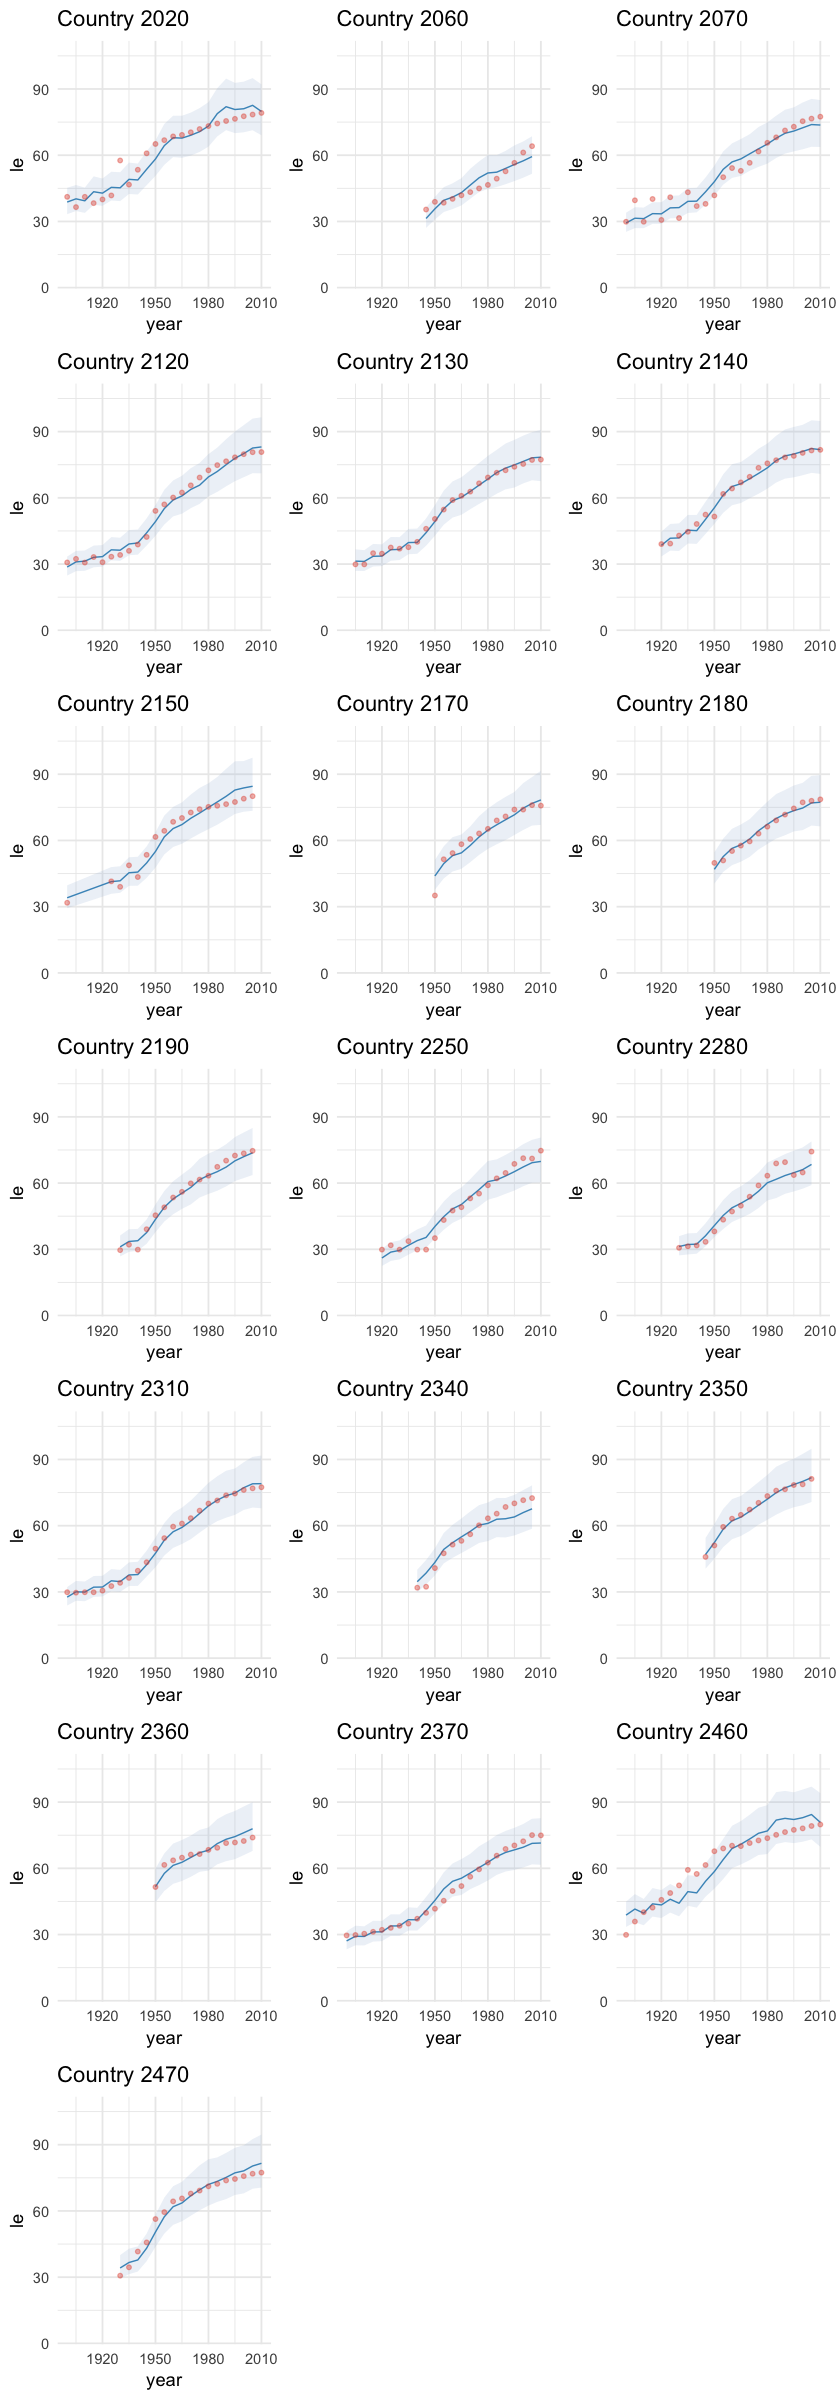

In [92]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(countries), collapse='+'), '+plot_layout(ncol = 3)')))